In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-27 10:02:08.877525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 10:02:09.591930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-27 10:02:11.181254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:11.268318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:11.268640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        images.append(np.array(im))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [4]:
T=600
beta = np.linspace(1e-4, 0.03, T)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [256,256]
tValues = np.arange(0,T)
# alphaBar = np.cos((tValues/(T+1) + 0.008)/(1 + 0.008) * np.pi/2) 
# np.random.shuffle(tValues)



def forwardStep(x0Image,t):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy


# Make a combination of all images and all possible t values and shuffle them
trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
shuffle(trainComb)
dataSize = len(trainComb)

#This generator provides all the timesteps for all images --> A huge dataset with comparably low variation
# def generator():
#     for fileIdx,tValue in trainComb:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         image = tf.convert_to_tensor(images[fileIdx])
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.95, 1.05)
#         image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = image.numpy()
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

repeats=3
def generator():
    for im in images:
        # image = tf.io.read_file(file)
        # image = tf.io.decode_jpeg(image, channels=3)
        image = tf.convert_to_tensor(im)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = image.numpy()
        for repeatIdx in range(repeats):
            tValue = np.random.randint(0,T)
            noise, noisy = forwardStep(x0, tValue)
            yield noisy, noise, [tValue], x0

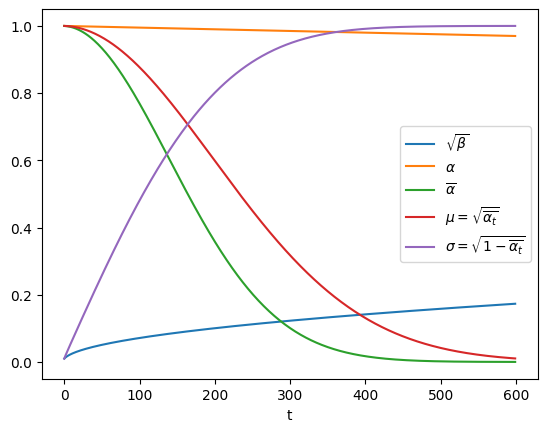

In [5]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
_ = plt.legend()
_ = plt.xlabel("t")

In [6]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [7]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[395]
(256, 256, 3)
(256, 256, 3)


2023-08-27 10:02:32.202581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:32.203151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:32.203548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:33.051483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 10:02:33.051837: I tensorflow/compile

In [8]:
test = next(g)
np.max(test[0])

4.334178052407142

Text(0.5, 1.0, 'Noise')

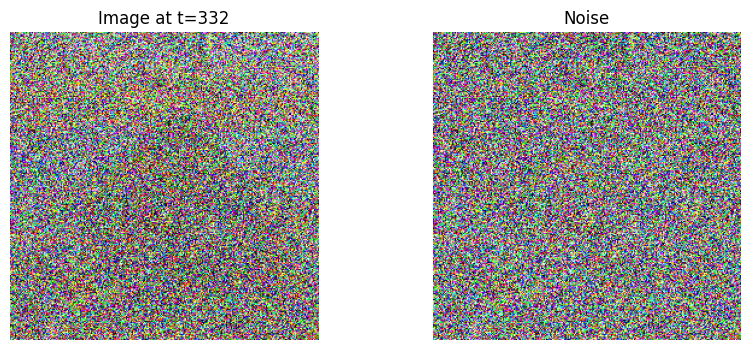

In [9]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]))
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]))
plt.axis('off')
plt.title("Noise")

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 255.5, 255.5, -0.5)

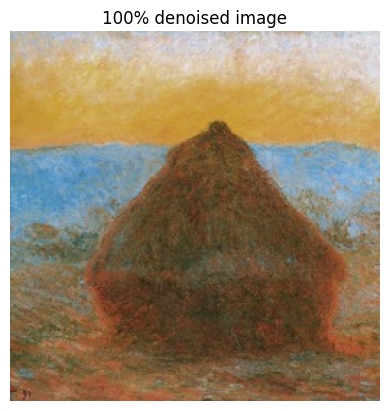

In [10]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [11]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

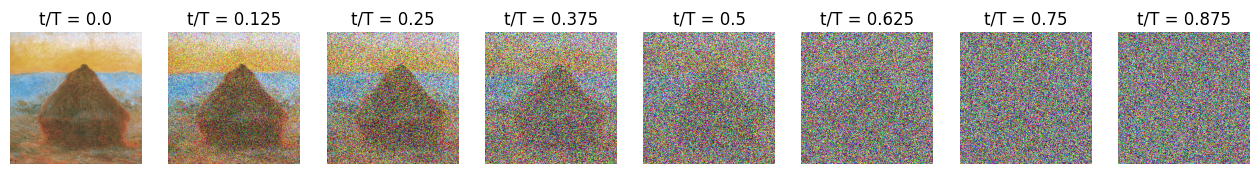

In [12]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]))
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [13]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStep(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t==0:
        sample = x0Pred
        noise= np.zeros(xt.shape)
    else:
        # estimate mean
        meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))

        # compute variance
        betaPred = np.sqrt(beta[t])

        sample = meanPred + betaPred*np.random.normal(0,1,xt.shape)

        noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise

for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStep(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

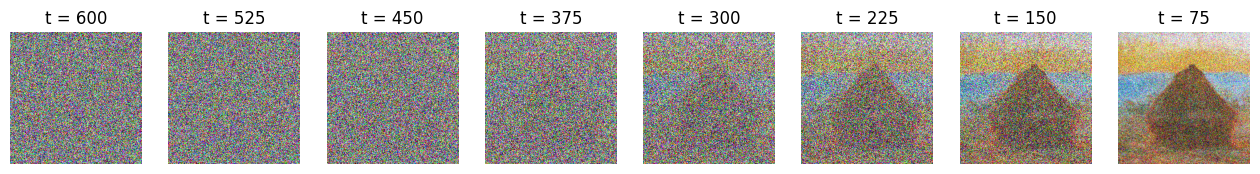

In [14]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]))
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

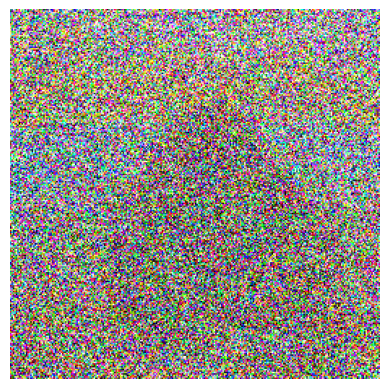

In [15]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))
_ = plt.imshow(np.clip(list(dataset.take(20))[1][0].numpy()/2+0.5, 0,1))
_ = plt.axis("off")

## Tensorflow

In [16]:
%load_ext tensorboard


In [17]:

def createSimpleUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(concatInput)
    xDown1 = tf.keras.layers.Conv2D(16, 3, padding="same", strides=2, activation="relu"  )(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"  )(xDown1)
    #128
    
    xDown2 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xDown1)
    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xDown2)
    #64

    xDown3 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xDown2)
    xDown3 = tf.keras.layers.Conv2D(64, 3, padding="same", strides=2, activation="relu"  )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"  )(xDown3)
    #32

    xCenter = tf.keras.layers.Conv2D(64, 3, padding="same" )(xDown3)

    stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=8, padding="same")(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(concatCenter)
    #32x32


    xUp3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(xCenter)
    xConcat3 = tf.keras.layers.Concatenate()([xUp3, xDown3])
    xUp3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xConcat3)
    xUp3 = tf.keras.layers.Conv2DTranspose(32, 3, padding="same", strides=2, activation="relu")(xUp3)
    xUp3 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xUp3)
    #64x64

    xUp2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(xUp3)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2])
    xUp2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(16, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xUp2)
    #128x128

    xUp1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(xUp2)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1])
    xUp1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(8, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(xUp1)
    #256x256

    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1In])
    x = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu")(xUp1)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnet")


# model = createSimpleUnet()

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


Model: "unet_T600_K2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 256)               153600    ['input_2[0][0]']             
                                                                                                  
 tf.repeat (TFOpLambda)      (None, 1, 256)               0         ['embedding[0][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                       

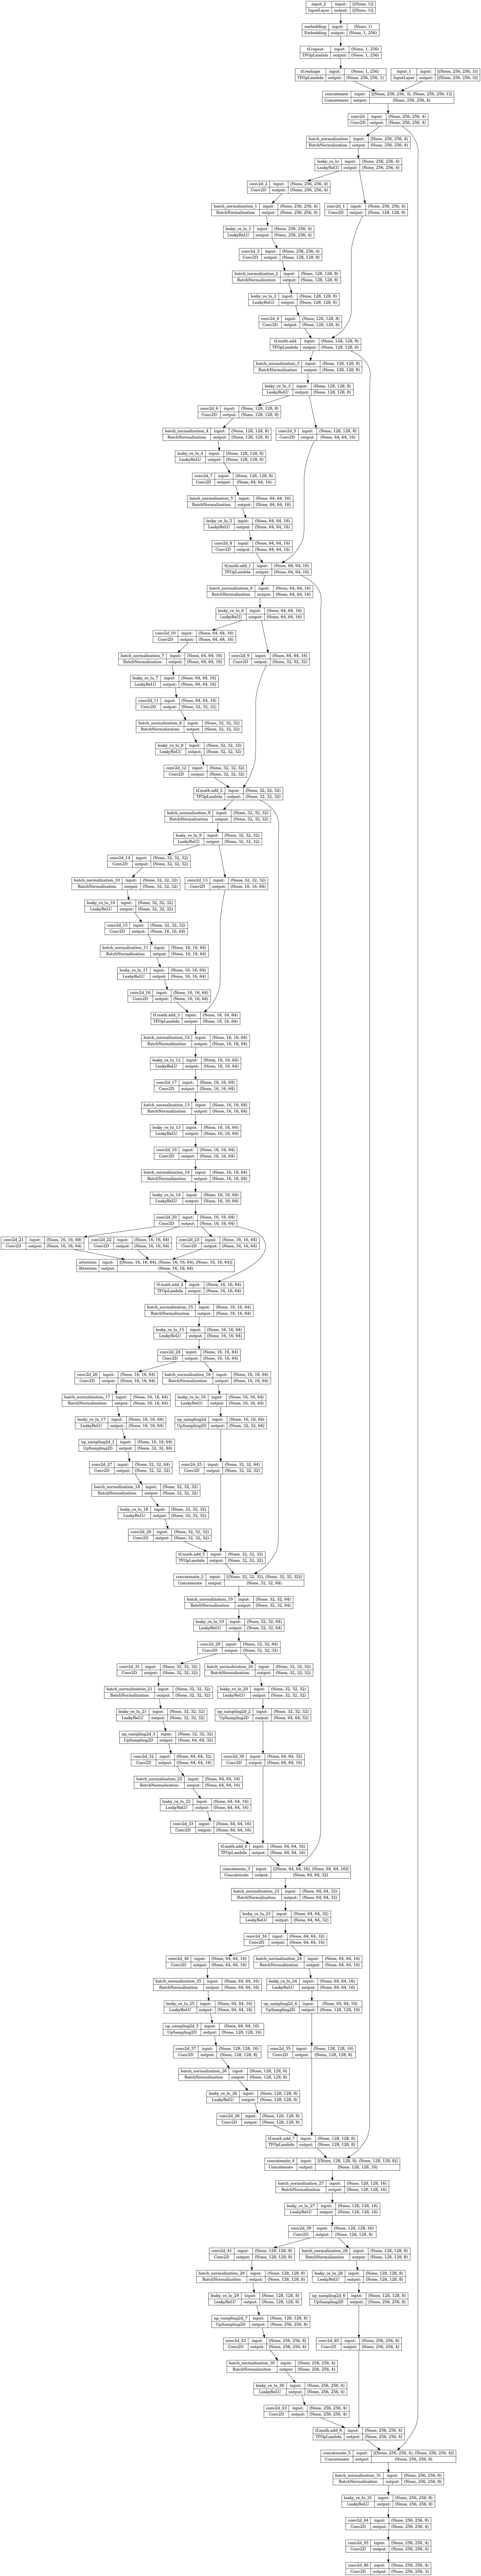

In [18]:
L2=0

def downscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)
    
    return added


def upscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)

    return added


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)


def centerBlock(xIn, stepMap, ch, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    stepMap16 = tf.keras.layers.Conv2D(3, filtersize, strides=16, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([x, stepMap16])

    x = tf.keras.layers.BatchNormalization()(concatCenter)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = nonLocalBlock(x, ch)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    return x

def createUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatInput)
    
    xDown4 = downscaleBlock(xDown2, K*2, K*4, 3)
    #128

    xDown8 = downscaleBlock(xDown4, K*4, K*8, 3)
    #64

    xDown16 = downscaleBlock(xDown8, K*8, K*16, 3)
    #32

    xDown32 = downscaleBlock(xDown16, K*16, K*32, 3)
    #16x16

    xCenter = centerBlock(xDown32, stepMap, K*32, 3)
    #16x16

    xUp16 = upscaleBlock(xCenter, K*32, K*16, 3)
    #32x32
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xDown16])
    xUp16 = tf.keras.layers.BatchNormalization()(xConcat16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
    xUp16=tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

    xUp8 = upscaleBlock(xUp16, K*16, K*8, 3)
    #64
    xConcat8 = tf.keras.layers.Concatenate()([xDown8, xUp8])
    xUp8 = tf.keras.layers.BatchNormalization()(xConcat8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
    xUp8=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

    xUp4 = upscaleBlock(xUp8, K*8, K*4, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])
    xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp2 = upscaleBlock(xUp4, K*4, K*2, 3)
    #256
    xConcat2 = tf.keras.layers.Concatenate()([xDown2, xUp2])
    
    x = tf.keras.layers.BatchNormalization()(xConcat2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_T{}_K{}".format(T,K))


model = createUnet()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [19]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "diffusionModel_epoch_0"))
    startEpoch=1
else:
    startEpoch=0

In [20]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
  initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(0,T)[::-1]:
      pred = model((samples[-1], tf.constant([t, t, t])), training=False)
      xt = samples[-1]
      
      # sample, noise = backwardStep(xt, t, x0Pred=predX0)
      sample, noise = backwardStep(xt, t, predNoise=pred)

      samples.append(sample)

  _ = plt.figure(figsize=(12,8))

  sampleIdx = np.linspace(0, T, 5)

  for j in range(3):
    for i in range(5):
        _ = plt.subplot(3, 5, j*5+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        if summary_writer is not None:
           with summary_writer.as_default():
              tf.summary.image("Training data", postprocessImage(samples[int(sampleIdx[-1])]), step=maxStep*epoch+step)
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [21]:
class MSESSIMLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super().__init__(name="MSE_SSIM_Loss")
        assert(alpha<1.0)
        self.alpha = tf.constant(alpha)
        
    def call(self, yTrue, yPred):
        mse =  tf.math.reduce_mean(tf.math.square(yPred - yTrue))
        ssim = tf.image.ssim(tf.clip_by_value(yPred,-1,1)/2+0.5, tf.clip_by_value(yTrue,-1,1)/2+0.5, max_val=1.0)
        ssimLoss =  1-tf.math.reduce_mean(ssim, axis=-1)
        return (1-self.alpha)*mse + self.alpha*ssimLoss

testLoss = MSESSIMLoss(0.2)
testLoss(tf.ones([1,20,20,3]), tf.ones([1,20,20,3])*0.9)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0084743025>

In [23]:

BATCH_SIZE=64
LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=60
epochs = 50
saveModel=True



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=6e-5)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = MSESSIMLoss(0.1)


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
# datasetShuffled = dataset.shuffle(200)
batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(noisyImage, noise, t):
    with tf.GradientTape() as tape:
        predicted = model((noisyImage, t), training=True) 

        loss = lossFn(predicted, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    return loss, predicted



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            ssim = tf.image.ssim(postprocessImage(predictedImage), postprocessImage(noise), max_val=1.0)
            template = 'Epoch {}/Step {}, Loss: {:.4f}, SSIM: {:.4f}'
            print(template.format(epoch, step, loss.numpy(), tf.math.reduce_mean(ssim).numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=maxStep*epoch+step)
                tf.summary.scalar('ssim', tf.math.reduce_mean(ssim), step=maxStep*epoch+step)
                summary_writer.flush()
        
        if step % SAVE_IMAGE_INTERVAL==0:
            saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    if saveModel:
      model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0
Epoch 0/Step 0, Loss: 0.0951, SSIM: 0.9421
Epoch 0/Step 5, Loss: 0.1231, SSIM: 0.9142
Epoch 0/Step 10, Loss: 0.0929, SSIM: 0.9433
Epoch 0/Step 15, Loss: 0.1149, SSIM: 0.9291
Epoch 0/Step 20, Loss: 0.1210, SSIM: 0.9155
Epoch 0/Step 25, Loss: 0.0892, SSIM: 0.9451
Epoch 0/Step 30, Loss: 0.1060, SSIM: 0.9284
Epoch 0/Step 35, Loss: 0.1677, SSIM: 0.8731
Epoch 0/Step 40, Loss: 0.1081, SSIM: 0.9314
Epoch 0/Step 45, Loss: 0.1046, SSIM: 0.9370
Epoch 0/Step 50, Loss: 0.1638, SSIM: 0.8865
Epoch 0/Step 55, Loss: 0.0836, SSIM: 0.9498
Epoch 0/Step 60, Loss: 0.1439, SSIM: 0.9057
Epoch 0/Step 65, Loss: 0.1256, SSIM: 0.9182
Epoch 0/Step 70, Loss: 0.1267, SSIM: 0.9128
Epoch 0/Step 75, Loss: 0.1250, SSIM: 0.9115
Epoch 0/Step 80, Loss: 0.1268, SSIM: 0.9158
Epoch 0/Step 85, Loss: 0.0920, SSIM: 0.9425


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_0/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_0/assets



Start of epoch 1
Epoch 1/Step 0, Loss: 0.1298, SSIM: 0.9147
Epoch 1/Step 5, Loss: 0.1220, SSIM: 0.9197
Epoch 1/Step 10, Loss: 0.1011, SSIM: 0.9420
Epoch 1/Step 15, Loss: 0.1094, SSIM: 0.9296
Epoch 1/Step 20, Loss: 0.1073, SSIM: 0.9258
Epoch 1/Step 25, Loss: 0.1305, SSIM: 0.9148
Epoch 1/Step 30, Loss: 0.1086, SSIM: 0.9347
Epoch 1/Step 35, Loss: 0.1451, SSIM: 0.8969
Epoch 1/Step 40, Loss: 0.1378, SSIM: 0.9122
Epoch 1/Step 45, Loss: 0.0955, SSIM: 0.9462
Epoch 1/Step 50, Loss: 0.0966, SSIM: 0.9456
Epoch 1/Step 55, Loss: 0.1148, SSIM: 0.9154
Epoch 1/Step 60, Loss: 0.1081, SSIM: 0.9268
Epoch 1/Step 65, Loss: 0.1091, SSIM: 0.9327
Epoch 1/Step 70, Loss: 0.0871, SSIM: 0.9436
Epoch 1/Step 75, Loss: 0.0650, SSIM: 0.9634
Epoch 1/Step 80, Loss: 0.0939, SSIM: 0.9434
Epoch 1/Step 85, Loss: 0.0848, SSIM: 0.9468


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_1/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_1/assets



Start of epoch 2
Epoch 2/Step 0, Loss: 0.1648, SSIM: 0.8841
Epoch 2/Step 5, Loss: 0.0974, SSIM: 0.9337
Epoch 2/Step 10, Loss: 0.0941, SSIM: 0.9442
Epoch 2/Step 15, Loss: 0.1359, SSIM: 0.9025
Epoch 2/Step 20, Loss: 0.0923, SSIM: 0.9332
Epoch 2/Step 25, Loss: 0.1307, SSIM: 0.9064
Epoch 2/Step 30, Loss: 0.1116, SSIM: 0.9301
Epoch 2/Step 35, Loss: 0.0698, SSIM: 0.9541
Epoch 2/Step 40, Loss: 0.0720, SSIM: 0.9583
Epoch 2/Step 45, Loss: 0.1428, SSIM: 0.8984
Epoch 2/Step 50, Loss: 0.1027, SSIM: 0.9296
Epoch 2/Step 55, Loss: 0.1130, SSIM: 0.9225
Epoch 2/Step 60, Loss: 0.0855, SSIM: 0.9491
Epoch 2/Step 65, Loss: 0.1100, SSIM: 0.9277
Epoch 2/Step 70, Loss: 0.1215, SSIM: 0.9197
Epoch 2/Step 75, Loss: 0.1380, SSIM: 0.9099
Epoch 2/Step 80, Loss: 0.1227, SSIM: 0.9198
Epoch 2/Step 85, Loss: 0.0990, SSIM: 0.9370


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_2/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_2/assets



Start of epoch 3
Epoch 3/Step 0, Loss: 0.0818, SSIM: 0.9489
Epoch 3/Step 5, Loss: 0.0600, SSIM: 0.9660
Epoch 3/Step 10, Loss: 0.1008, SSIM: 0.9351
Epoch 3/Step 15, Loss: 0.1286, SSIM: 0.9142
Epoch 3/Step 20, Loss: 0.0936, SSIM: 0.9461
Epoch 3/Step 25, Loss: 0.1332, SSIM: 0.9114
Epoch 3/Step 30, Loss: 0.1039, SSIM: 0.9353
Epoch 3/Step 35, Loss: 0.0990, SSIM: 0.9426
Epoch 3/Step 40, Loss: 0.1167, SSIM: 0.9272
Epoch 3/Step 45, Loss: 0.1315, SSIM: 0.9156
Epoch 3/Step 50, Loss: 0.1020, SSIM: 0.9377
Epoch 3/Step 55, Loss: 0.0625, SSIM: 0.9650
Epoch 3/Step 60, Loss: 0.1198, SSIM: 0.9213
Epoch 3/Step 65, Loss: 0.1280, SSIM: 0.9143
Epoch 3/Step 70, Loss: 0.1688, SSIM: 0.8827
Epoch 3/Step 75, Loss: 0.0904, SSIM: 0.9464
Epoch 3/Step 80, Loss: 0.1279, SSIM: 0.9136
Epoch 3/Step 85, Loss: 0.1177, SSIM: 0.9219


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_3/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_3/assets



Start of epoch 4
Epoch 4/Step 0, Loss: 0.1093, SSIM: 0.9299
Epoch 4/Step 5, Loss: 0.0999, SSIM: 0.9355
Epoch 4/Step 10, Loss: 0.1214, SSIM: 0.9186
Epoch 4/Step 15, Loss: 0.1071, SSIM: 0.9245
Epoch 4/Step 20, Loss: 0.1314, SSIM: 0.9093
Epoch 4/Step 25, Loss: 0.0862, SSIM: 0.9453
Epoch 4/Step 30, Loss: 0.1235, SSIM: 0.9120
Epoch 4/Step 35, Loss: 0.0897, SSIM: 0.9469
Epoch 4/Step 40, Loss: 0.0734, SSIM: 0.9572
Epoch 4/Step 45, Loss: 0.0819, SSIM: 0.9534
Epoch 4/Step 50, Loss: 0.1090, SSIM: 0.9311
Epoch 4/Step 55, Loss: 0.0887, SSIM: 0.9479
Epoch 4/Step 60, Loss: 0.0701, SSIM: 0.9586
Epoch 4/Step 65, Loss: 0.1359, SSIM: 0.9061
Epoch 4/Step 70, Loss: 0.0777, SSIM: 0.9528
Epoch 4/Step 75, Loss: 0.1197, SSIM: 0.9225
Epoch 4/Step 80, Loss: 0.0861, SSIM: 0.9493
Epoch 4/Step 85, Loss: 0.1205, SSIM: 0.9214


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_4/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_4/assets



Start of epoch 5
Epoch 5/Step 0, Loss: 0.1384, SSIM: 0.9094
Epoch 5/Step 5, Loss: 0.0918, SSIM: 0.9435
Epoch 5/Step 10, Loss: 0.1404, SSIM: 0.9126
Epoch 5/Step 15, Loss: 0.1179, SSIM: 0.9289
Epoch 5/Step 20, Loss: 0.1030, SSIM: 0.9297
Epoch 5/Step 25, Loss: 0.1185, SSIM: 0.9239
Epoch 5/Step 30, Loss: 0.1274, SSIM: 0.9151
Epoch 5/Step 35, Loss: 0.1190, SSIM: 0.9201
Epoch 5/Step 40, Loss: 0.1433, SSIM: 0.8977
Epoch 5/Step 45, Loss: 0.0926, SSIM: 0.9440
Epoch 5/Step 50, Loss: 0.1317, SSIM: 0.9071
Epoch 5/Step 55, Loss: 0.1183, SSIM: 0.9208
Epoch 5/Step 60, Loss: 0.1431, SSIM: 0.9013
Epoch 5/Step 65, Loss: 0.0610, SSIM: 0.9654
Epoch 5/Step 70, Loss: 0.1119, SSIM: 0.9288
Epoch 5/Step 75, Loss: 0.0869, SSIM: 0.9498
Epoch 5/Step 80, Loss: 0.1155, SSIM: 0.9328
Epoch 5/Step 85, Loss: 0.1123, SSIM: 0.9213


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_5/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_5/assets



Start of epoch 6
Epoch 6/Step 0, Loss: 0.1129, SSIM: 0.9245
Epoch 6/Step 5, Loss: 0.1478, SSIM: 0.8993
Epoch 6/Step 10, Loss: 0.1327, SSIM: 0.9174
Epoch 6/Step 15, Loss: 0.1006, SSIM: 0.9392
Epoch 6/Step 20, Loss: 0.1333, SSIM: 0.9078
Epoch 6/Step 25, Loss: 0.1145, SSIM: 0.9231
Epoch 6/Step 30, Loss: 0.0999, SSIM: 0.9343
Epoch 6/Step 35, Loss: 0.0952, SSIM: 0.9445
Epoch 6/Step 40, Loss: 0.0793, SSIM: 0.9569
Epoch 6/Step 45, Loss: 0.1260, SSIM: 0.9244
Epoch 6/Step 50, Loss: 0.0808, SSIM: 0.9507
Epoch 6/Step 55, Loss: 0.1103, SSIM: 0.9308
Epoch 6/Step 60, Loss: 0.1765, SSIM: 0.8683
Epoch 6/Step 65, Loss: 0.0873, SSIM: 0.9487
Epoch 6/Step 70, Loss: 0.1494, SSIM: 0.8979
Epoch 6/Step 75, Loss: 0.1122, SSIM: 0.9307
Epoch 6/Step 80, Loss: 0.0602, SSIM: 0.9653
Epoch 6/Step 85, Loss: 0.1100, SSIM: 0.9296


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_6/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_6/assets



Start of epoch 7
Epoch 7/Step 0, Loss: 0.1254, SSIM: 0.9118


KeyboardInterrupt: 

In [ ]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]

for t in np.arange(0,T)[::-1]:
    predNoise = model((samples[-1], tf.constant([t,t])))
    xt = samples[-1]
    
    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, T, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

In [ ]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)
plt.title("Predicted Noise")
plt.subplot(1,2,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+1)/2)

In [ ]:
testTNum = testT.numpy()[0][0]

In [ ]:
denoised = (testImage - (1-alpha[testTNum])/np.sqrt(1-alphaBar[testTNum])*predNoise)/np.sqrt(alpha[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised Image by 1 step")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)